In [921]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

# 1. Load raw data
df = pd.read_csv('pilot1_fixed.csv')

# 2. Shift ITI up two rows within each participant so it aligns with the choice row
df['ITI (s)'] = (
    df.groupby('Participant')['ITI (s)']
      .transform(lambda x: x.shift(2))
)

# 3. Filter out practice trials (keep Trial >= 22)
df = df[df['Trial'] >= 22]

# 4. Keep only choice trials with responses 'q', 't', or 'p'
df = df[df['Choice'].isin(['q', 't', 'p'])].copy()

# 5. Map Feedback to binary outcome: +1.00$ → 1, else → -1
df['feedback_value'] = (
    df['Feedback'].str.extract(r'([+-]?\d+\.?\d*)')[0].astype(float)
)
df['outcome'] = np.where(df['feedback_value'] > 0, 1, -1)
df.drop(columns='feedback_value', inplace=True)

# 6. Rename columns
df = df.rename(columns={
    'Participant':    'sub',
    'Choice':         'choice',
    'Chosen Probability': 'chosen_prob',
    'ITI (s)':        'ITI',
})

# 7. Map choice letters to numeric codes: q->0, t->1, p->2
df['choice'] = df['choice'].map({'q': 0, 't': 1, 'p': 2}).astype(int)

# 8. Select and reorder columns
df = df[['sub', 'choice', 'chosen_prob', 'ITI', 'outcome',
         'Trial', 'RT', 'Response']]

# 9. Create new trial index and block
df['trial']          = df.groupby('sub').cumcount()
df['block']          = (df['trial'] // 42).astype(int)
df['trial_in_round'] = df.groupby(['sub', 'block']).cumcount() + 1

# ------------------------------------------------------------------
# 9-BIS.  Carry ITI from missing-response trials onto the next trial
# ------------------------------------------------------------------
def carry_iti(group):
    """
    For each participant:
      * accumulate ITIs for rows with NaN Response;
      * add that total to the first subsequent valid-response row;
      * drop the NaN-response rows.
    """
    carry = 0.0
    keep_rows = []
    for idx, row in group.iterrows():
        if pd.isna(row['Response']):
            carry += 0.0 if idx>-10 else 0.0
            # skip this row (it will be dropped)
        else:
            row['ITI'] = (row['ITI'] if not pd.isna(row['ITI']) else 0.0) + carry
            carry = 0.0
            keep_rows.append(row)
    return pd.DataFrame(keep_rows)

df = (
    df.sort_values(['sub', 'trial'])
      .groupby('sub', group_keys=False)
      .apply(carry_iti)
      .reset_index(drop=True)
)

# 10. Final reorder and derived columns
df['RT'] = df['RT'] / 1000.0  # ms → s
df['total_ITI']      = df['RT'] + df['ITI']
df['total_ITI_log']  = np.log(df['total_ITI'])

df = df[['sub', 'trial', 'trial_in_round', 'block',
         'choice', 'chosen_prob', 'RT', 'ITI',
         'total_ITI', 'total_ITI_log', 'outcome', 'Response']]

print(df.head())

# 1. Compute number of missing Responses per subject
nan_counts = df['Response'].isna().groupby(df['sub']).sum()

# 2. Identify “bad” subjects with >20 missing
bad_subs = nan_counts[nan_counts > 20].index

# 3. Filter out all rows for those subjects
data = df[~df['sub'].isin(bad_subs)].copy()




# ------------------------------------------------------------------
# Filter 1: subjects with >4 missing trials in any block
# ------------------------------------------------------------------
EXPECTED_TRIALS = 42            # change if your block length differs

# how many rows actually remain for every (sub, block)?
trial_counts = (
    data
    .groupby(['sub', 'block'])
    .size()
    .reset_index(name='n_trials')
)

# subjects short by >4 trials in ANY block
subs_with_big_gaps = (
    trial_counts
      .loc[trial_counts['n_trials'] < (EXPECTED_TRIALS - 7), 'sub']
      .unique()
)

# ------------------------------------------------------------------
# Filter 2: subjects who switch >90 % of the time
# ------------------------------------------------------------------
# make sure 'stay' is defined (skip the very first trial per subject)
data = data.sort_values(['sub', 'block', 'trial_in_round'])
data['prev_choice'] = data.groupby('sub')['choice'].shift(1)
data['stay'] = (data['choice'] == data['prev_choice']).astype(int)

stay_rates = (
    data
    .groupby('sub')['stay']
    .mean()                      # proportion of “stay” trials
    .reset_index(name='stay_rate')
)

subs_high_switch = stay_rates.loc[stay_rates['stay_rate'] < 0.10, 'sub'].unique()

# ------------------------------------------------------------------
# Combine the two exclusion lists and drop from the DataFrame
# ------------------------------------------------------------------
subs_to_drop = set(subs_with_big_gaps) | set(subs_high_switch)

print(f"Excluding {len(subs_to_drop)} subjects total "
      f"({len(subs_with_big_gaps)} for missing trials, "
      f"{len(subs_high_switch)} for excessive switching).")

data = data[~data['sub'].isin(subs_to_drop)].copy()
data = data.reset_index(drop=True)



median_by_sub = data.groupby('sub')['total_ITI'].transform('median')

# Numeric: 1 if > median, –1 if ≤ median, “–” if NaN
data['ITI_Type_Numeric'] = np.where(
    data['total_ITI'].isna(),
    np.nan,
    np.where(data['total_ITI'] > median_by_sub, 1, -1)
)

# Categorical: “Long” if > median, “Short” if ≤ median, “–” if NaN
data['ITI_Type'] = np.where(
    data['total_ITI'].isna(),
    '',
    np.where(data['total_ITI'] > median_by_sub, 'Long', 'Short')
)
data=data.reset_index(drop=True)

data.to_csv('preprocessed_data.csv', index=False)

print("Done! 'preprocessed_data.csv' generated.")


                                 sub  trial  trial_in_round  block  choice  \
0  prolific_59e4b3a1896cfc0001921095      0               1      0       0   
1  prolific_59e4b3a1896cfc0001921095      1               2      0       1   
2  prolific_59e4b3a1896cfc0001921095      2               3      0       1   
3  prolific_59e4b3a1896cfc0001921095      3               4      0       1   
4  prolific_59e4b3a1896cfc0001921095      4               5      0       2   

   chosen_prob     RT       ITI  total_ITI  total_ITI_log  outcome Response  
0          0.5  0.830  0.000000   0.830000      -0.186330       -1        q  
1          0.3  1.350  4.656451   6.006451       1.792834       -1        t  
2          0.3  1.809  4.125859   5.934859       1.780843        1        t  
3          0.3  0.958  3.885357   4.843357       1.577608       -1        t  
4          0.7  0.772  1.240782   2.012782       0.699518        1        p  
Excluding 3 subjects total (1 for missing trials, 2 for excessi

C:\Users\sharp\AppData\Local\Temp\ipykernel_26796\967506622.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(carry_iti)


In [93]:
# שלב 0: ייבוא ספריות
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load and remap 'choice' from integers back to bandit letters ---
data = pd.read_csv('preprocessed_data.csv')
data = data.dropna(subset=['choice'])
# assume in your CSV choice was 0→q, 1→t, 2→p
data['choice_numeric'] = data['choice'].map({0: 0, 1: 1, 2: 2})

data['choice'] = data['choice'].map({0: 'q', 1: 't', 2: 'p'})

def compute_running_rewards(df):
    # reset round counter each time trial==42 within each subject
    df["round"] = df['block']
    

    def update_rewards(group):
        pdelta_w = pdelta_l = qdelta_w = qdelta_l = tdelta_w = tdelta_l = 1
        reward_q = reward_t = reward_p = 0.5
        reward_q_list = []
        reward_t_list = []
        reward_p_list = []

        for _, row in group.iterrows():
            # win/loss counters
            if row["outcome"] == 1:
                delta_w, delta_l = 1, 0
            elif row["outcome"] == -1:
                delta_w, delta_l = 0, 1
            else:
                delta_w = delta_l = 0

            # update running average for the chosen bandit
            if row["choice"] == "q":
                qdelta_w += delta_w
                qdelta_l += delta_l
                reward_q = qdelta_w / (qdelta_w + qdelta_l) if (qdelta_w + qdelta_l) > 0 else 0
            elif row["choice"] == "t":
                tdelta_w += delta_w
                tdelta_l += delta_l
                reward_t = tdelta_w / (tdelta_w + tdelta_l) if (tdelta_w + tdelta_l) > 0 else 0
            elif row["choice"] == "p":
                pdelta_w += delta_w
                pdelta_l += delta_l
                reward_p = pdelta_w / (pdelta_w + pdelta_l) if (pdelta_w + pdelta_l) > 0 else 0

            reward_q_list.append(reward_q)
            reward_t_list.append(reward_t)
            reward_p_list.append(reward_p)

        group["actual_reward_q"] = reward_q_list
        group["actual_reward_t"] = reward_t_list
        group["actual_reward_p"] = reward_p_list
        return group

    return df.groupby(["sub", "round"], group_keys=False).apply(update_rewards)

# compute running rewards
data = compute_running_rewards(data)

# Step 1: within-round trial index

# Step 2: before/after midpoint of a 42-trial round
data['phase_round'] = np.where(data['trial_in_round'] < 22, 'before', 'after')

# map outcome strings to numeric (if not already numeric)
outcome_map = {1: 1, -1: -1}

# create last-outcome columns for each bandit
for bandit in ['q', 't', 'p']:
    temp = f"{bandit}_temp"
    last = f"{bandit}_last_outcome"
    data[temp] = np.where(data['choice'] == bandit,
                          data['outcome'].map(outcome_map),
                          np.nan)
    data[last] = data.groupby(['sub', 'round'])[temp].ffill().shift(1)
    data.drop(columns=temp, inplace=True)

# fill NaNs with 0
for col in ['q_last_outcome', 't_last_outcome', 'p_last_outcome']:
    data[col].fillna(0, inplace=True)

# 3-state “chose best last outcome” (1 if you picked the bandit with highest last outcome)
def chose_best_lastoutcome_func(row):
    outcomes = {
        'q': row['q_last_outcome'],
        't': row['t_last_outcome'],
        'p': row['p_last_outcome']
    }
    max_out = max(outcomes.values())
    if max_out == 0:
        return 0
    return 1 if outcomes[row['choice']] == max_out else 0

data['chose_best_lastoutcome'] = data.apply(chose_best_lastoutcome_func, axis=1)

import numpy as np

# 1. Make sure your outcome is numeric: +1 for win, –1 for loss
#    If it's already numeric you can skip this mapping.
outcome_map = {1: 1, -1: -1}
data['outcome_num'] = data['outcome'].map(outcome_map)

# 2. Grab the previous trial’s choice and outcome (within each subject & round)
data['prev_choice']  = data.groupby(['sub', 'round'])['choice'].shift(1)
data['prev_outcome'] = data.groupby(['sub', 'round'])['outcome_num'].shift(1)

# 3. Compute WSLS: 1 if (win → stayed) OR (loss → switched), else 0
wsls = (
    ((data['prev_outcome'] == 1) & (data['choice'] == data['prev_choice'])) |
    ((data['prev_outcome'] == -1) & (data['choice'] != data['prev_choice']))
)
data['wsls'] = wsls.astype(int).fillna(0)

# 4. (Optional) clean up temporary columns
data.drop(columns=['outcome_num', 'prev_choice', 'prev_outcome'], inplace=True)

data["ITI_Rounded"] = np.round(data["ITI"])

# previous actual rewards (shifted)
for bandit in ['q', 't', 'p']:
    data[f"prev_actual_reward_{bandit}"] = data.groupby(['sub','round'])[f"actual_reward_{bandit}"].shift(1)

# choose_actual_best: was the choice in the top-1 or top-2 of prev rewards?
def determine_choice(row, threshold=0.0):
    if pd.isna(row.prev_actual_reward_q) or pd.isna(row.prev_actual_reward_t) or pd.isna(row.prev_actual_reward_p):
        return np.nan
    rewards = {
        'q': row.prev_actual_reward_q,
        't': row.prev_actual_reward_t,
        'p': row.prev_actual_reward_p
    }
    sorted_b = sorted(rewards.items(), key=lambda x: x[1], reverse=True)
    (best1, v1), (best2, v2), _ = sorted_b
    if (v1 - v2) <= threshold:
        correct = {best1, best2}
    else:
        correct = {best1}
    if v1==v2:
        return 0.5
    else:
        return 1 if row.choice in correct else 0

data['choose_actual_best'] = data.apply(determine_choice, axis=1)

# finally, inspect
print(data[['sub','block','trial_in_round','choice','prev_actual_reward_q',
            'prev_actual_reward_t','prev_actual_reward_p','choose_actual_best','ITI']].head(20))
# create last_ITI: NaN for the first trial in each block, otherwise the previous trial’s ITI

# inspect
unique_participants = sorted(data["sub"].unique())
participant_numbering = {participant: str(i + 1) for i, participant in enumerate(unique_participants)}

data["sub_num"] = data["sub"].map(participant_numbering)

# (optional) save out
data.to_csv('new_data.csv', index=False)


                                  sub  block  trial_in_round choice  \
0   prolific_59e4b3a1896cfc0001921095      0               1      q   
1   prolific_59e4b3a1896cfc0001921095      0               2      t   
2   prolific_59e4b3a1896cfc0001921095      0               3      t   
3   prolific_59e4b3a1896cfc0001921095      0               4      t   
4   prolific_59e4b3a1896cfc0001921095      0               5      p   
5   prolific_59e4b3a1896cfc0001921095      0               6      p   
6   prolific_59e4b3a1896cfc0001921095      0               7      p   
7   prolific_59e4b3a1896cfc0001921095      0               8      p   
8   prolific_59e4b3a1896cfc0001921095      0               9      p   
9   prolific_59e4b3a1896cfc0001921095      0              10      p   
10  prolific_59e4b3a1896cfc0001921095      0              11      p   
11  prolific_59e4b3a1896cfc0001921095      0              12      p   
12  prolific_59e4b3a1896cfc0001921095      0              13      p   
13  pr

prior for q 
wins=1
losses=1

expectation for winning with option q before getting any experience with q

wins/(wins+losses)=50%

trial 1 I choose q and I lose

wins=1
losses=2

at trial 2

2/(2+2) = ? 0.3333



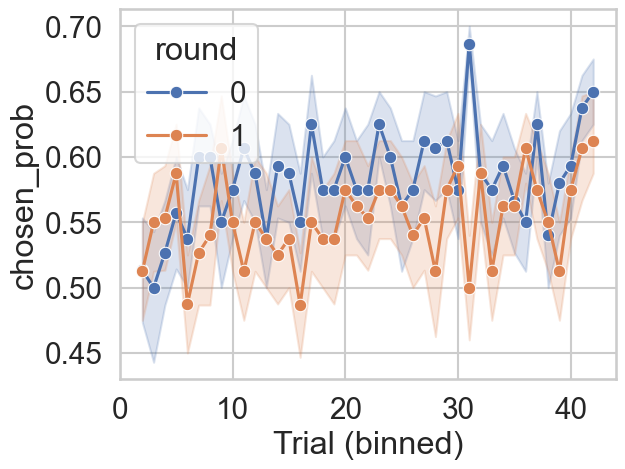

Index(['sub', 'trial', 'trial_in_round', 'block', 'choice', 'chosen_prob',
       'RT', 'ITI', 'total_ITI', 'total_ITI_log', 'outcome', 'Response',
       'stay', 'ITI_Type_Numeric', 'ITI_Type', 'choice_numeric', 'round',
       'actual_reward_q', 'actual_reward_t', 'actual_reward_p', 'phase_round',
       'q_last_outcome', 't_last_outcome', 'p_last_outcome',
       'chose_best_lastoutcome', 'wsls', 'ITI_Rounded', 'prev_actual_reward_q',
       'prev_actual_reward_t', 'prev_actual_reward_p', 'choose_actual_best',
       'sub_num', 'trial_bin', 'bestchoice', 'logRT', 'zRT', 'zITI', 'RTz'],
      dtype='object')


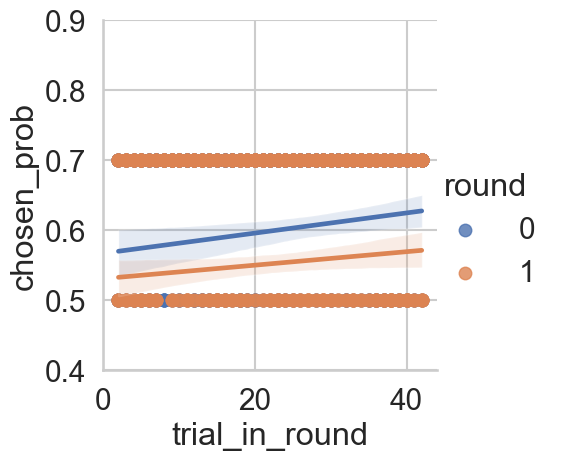

In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 1) Create a 5‐trial bin index
data['trial_bin'] = (data['trial_in_round'] // 1) 
data['bestchoice'] = [1 if x==0.7 else 0 for x in data['chosen_prob']]
choice_var='chosen_prob'
data=data[data['trial_in_round']>1]
# 2) Compute the mean chosen_prob in each bin, separately for each round
smoothed = (
    data
    .groupby(['round', 'trial_bin','sub'])[choice_var]
    .mean()
    .reset_index()
)

# 3) Plot the smoothed curve
sns.lineplot(
    x='trial_bin',
    y=choice_var,
    hue='round',
    data=smoothed,
    ci=68,
    marker='o'
)
plt.xlabel('Trial (binned)')
plt.savefig('Learning_curves.png',dpi=300,bbox_inches='tight')
plt.show()
print(data.columns)

ax=sns.lmplot(x='trial_in_round',y=choice_var,robust=True,hue='round',data=data) #look up default for error shade.
plt.ylim([0.4,0.9])
plt.show()

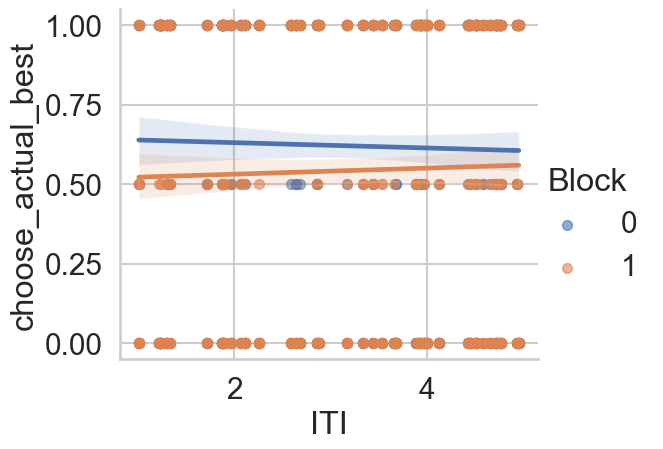

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1)  Plot with larger fonts
# -------------------------------------------------
sns.set_context("talk", font_scale=1.3)   # ← makes everything bigger
g = sns.lmplot(
    data=data,
    x='ITI',
    y='choose_actual_best',
    hue='block',
    logistic=False,
    robust=True,
    height=5, aspect=1.2,           # a bit roomier
    scatter_kws=dict(alpha=.6, s=50)
)

# -------------------------------------------------
# 2)  Y-axis as “% chose best”
# -------------------------------------------------
ax = g.ax                          # lmplot returns a FacetGrid; g.ax is its axis


# -------------------------------------------------
# 3)  Legend outside on the right
# -------------------------------------------------
g.legend.set_title('Block')              # optional – prettier legend title
g.legend.set_frame_on(False)             # no box (optional)

# -------------------------------------------------
# 4)  Save & show
# -------------------------------------------------
plt.show()


In [109]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd

choice_var = 'choose_actual_best'

# -------------------------------------------------
# 0) keep only rows with complete data we need
# -------------------------------------------------
cols = [choice_var, 'ITI','logRT', 'sub','round', 'trial_in_round']
df   = data[cols].dropna().copy()

# -------------------------------------------------
# 1) fit GLM with cluster-robust SEs by subject
# -------------------------------------------------
logit_mod = smf.ols(
    formula = f"{choice_var} ~ ITI*round ",
    data    = df,
    family  = sm.families.Gaussian()
).fit()

print(logit_mod.summary())

# -------------------------------------------------
# 2) odds-ratios (exp(beta)) with 95 % CIs
# -------------------------------------------------
params    = logit_mod.params
conf_int  = logit_mod.conf_int()
or_table  = np.exp(np.column_stack([params, conf_int]))
or_df     = pd.DataFrame(or_table,
                         index=params.index,           # <- auto names
                         columns=['OR', 'CI low', 'CI high']).round(3)

print("\nOdds-ratios:")
print(or_df)


                            OLS Regression Results                            
Dep. Variable:     choose_actual_best   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.164
Date:                Sun, 27 Jul 2025   Prob (F-statistic):             0.0238
Time:                        12:35:38   Log-Likelihood:                -840.50
No. Observations:                1276   AIC:                             1689.
Df Residuals:                    1272   BIC:                             1710.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6472      0.051     12.686      0.0

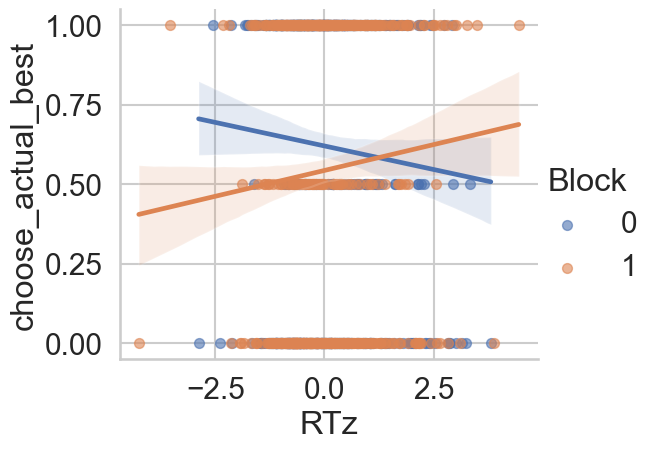

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

data['RTz'] = data.groupby(['sub', 'round'])['logRT'].transform(lambda x: (x - x.mean()) / x.std(ddof=1))

# -------------------------------------------------
# 1)  Plot with larger fonts
# -------------------------------------------------
sns.set_context("talk", font_scale=1.3)   # ← makes everything bigger
g = sns.lmplot(
    data=data,
    x='RTz',
    y='choose_actual_best',
    hue='block',
    logistic=False,
    robust=True,
    height=5, aspect=1.2,           # a bit roomier
    scatter_kws=dict(alpha=.6, s=50)
)

# -------------------------------------------------
# 2)  Y-axis as “% chose best”
# -------------------------------------------------
ax = g.ax                          # lmplot returns a FacetGrid; g.ax is its axis


# -------------------------------------------------
# 3)  Legend outside on the right
# -------------------------------------------------
g.legend.set_title('Block')              # optional – prettier legend title
g.legend.set_frame_on(False)             # no box (optional)

# -------------------------------------------------
# 4)  Save & show
# -------------------------------------------------
plt.savefig('effectITI_bothrounds.png', dpi=300, bbox_inches='tight')
plt.show()


In [111]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd

choice_var = 'choose_actual_best'

# -------------------------------------------------
# 0) keep only rows with complete data we need
# -------------------------------------------------
cols = [choice_var, 'ITI','RTz', 'sub','round', 'trial_in_round']
df   = data[cols].dropna().copy()

# -------------------------------------------------
# 1) fit GLM with cluster-robust SEs by subject
# -------------------------------------------------
logit_mod = smf.ols(
    formula = f"{choice_var} ~ RTz*round ",
    data    = df,
    family  = sm.families.Gaussian()
).fit()

print(logit_mod.summary())

# -------------------------------------------------
# 2) odds-ratios (exp(beta)) with 95 % CIs
# -------------------------------------------------
params    = logit_mod.params
conf_int  = logit_mod.conf_int()
or_table  = np.exp(np.column_stack([params, conf_int]))
or_df     = pd.DataFrame(or_table,
                         index=params.index,           # <- auto names
                         columns=['OR', 'CI low', 'CI high']).round(3)

print("\nOdds-ratios:")
print(or_df)


                            OLS Regression Results                            
Dep. Variable:     choose_actual_best   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.744
Date:                Sun, 27 Jul 2025   Prob (F-statistic):            0.00270
Time:                        12:39:37   Log-Likelihood:                -838.14
No. Observations:                1276   AIC:                             1684.
Df Residuals:                    1272   BIC:                             1705.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6201      0.019     33.424      0.0

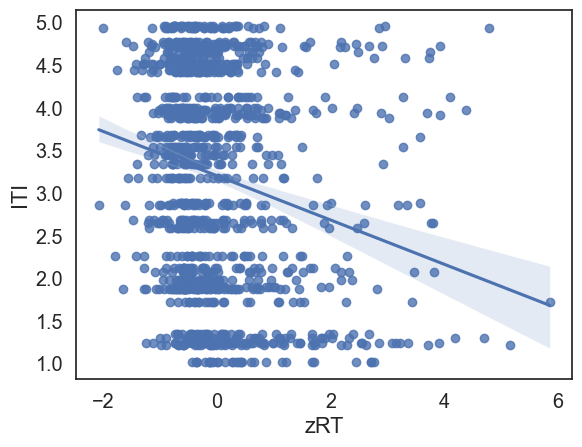

In [116]:
# data["ITI_Type"] = data["ITI (s)"].apply(
#     lambda x: "Short" if x < 1.5 else ("Long" if x > 4.5 else "Medium")
# )

sns.set(font_scale=1.3,style='white')
data['logRT']=np.log(data['RT'])
data['bestchoice']=[1 if x==0.7 else 0 if x==0.3 else x for x in data['chosen_prob']]

#set variables
choice_var='choose_actual_best'
round_task='both'

# --- 1.  Standardise RT and ITI within subject -----------------------
# z = (value – subject-mean) / subject-SD
data[['zRT', 'zITI']] = (
    data.groupby(['sub', 'round'])[['RT', 'ITI']]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))  # ddof=0 → population SD
)



sns.regplot(data=data,x='zRT',y='ITI',robust=True)
plt.savefig('effectITI_onRT.png'.format(round_task), dpi=300)

plt.show()


ROUND 1 EFFECTS


Slope β  vs.  mean_chosen_prob   :  ρ = -0.149,  p = 0.5814
Slope β  vs.  mean_RT (intercept):  ρ = -0.005,  p = 0.9858


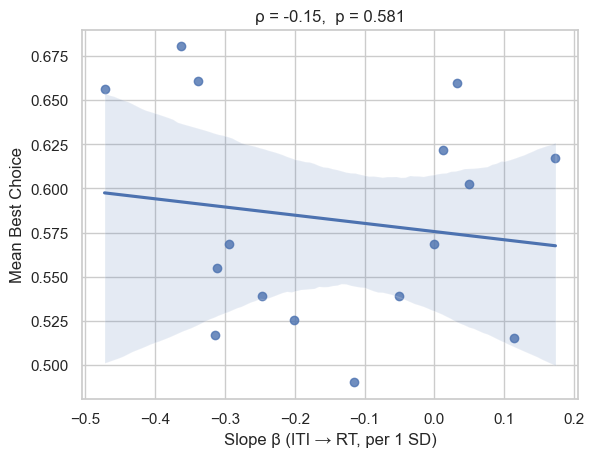

ROUND 2 EFFECTS


Slope β  vs.  mean_chosen_prob   :  ρ = 0.555,  p = 0.02564
Slope β  vs.  mean_RT (intercept):  ρ = -0.251,  p = 0.3478


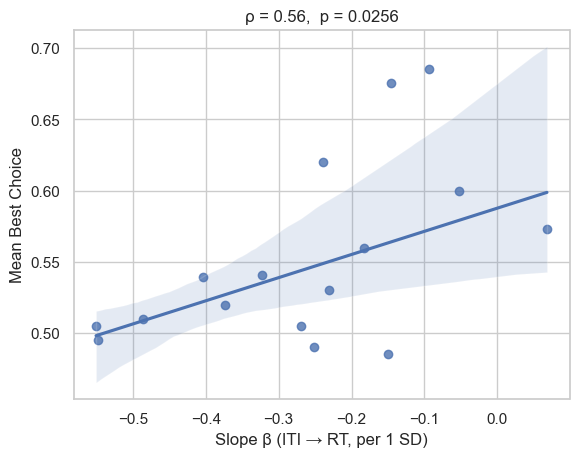

In [156]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr as corrp
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
choice_var = 'chosen_prob'
data['logRT']=np.log(data['RT'])
# -----------------------------------------------------------
# 1) Filter rows with valid data
# -----------------------------------------------------------
df = data.dropna(subset=['RT','ITI','RTz', choice_var, 'sub_num','block']).copy()
print('ROUND 1 EFFECTS\n\n')
df=df[df['block']==0]
# df   = df[df['logRT'] >= -2]

# -----------------------------------------------------------
# 2) Per-participant OLS:  RT ~ 1 + z(ITI)
# -----------------------------------------------------------
records = []
for subj, g in df.groupby('sub'):
    if len(g) < 5:
        continue
    iti_z = (g['ITI'] - g['ITI'].mean()) / g['ITI'].std(ddof=0)  # z-score ITI
    X = sm.add_constant(iti_z)
    res = sm.RLM(g['RTz'],X,robust=True).fit()
    records.append({
        'sub'            : subj,
        'beta_ITI_to_RT' : res.params[1],          # slope per 1 SD ITI
        'mean_RT'        : res.params[0],          # intercept = mean RT
        'mean_chosen_prob': g[choice_var].mean()
    })

beta_df = pd.DataFrame(records)

# -----------------------------------------------------------
# 3) Correlations
# -----------------------------------------------------------
r_cp, p_cp = corrp(beta_df['beta_ITI_to_RT'], beta_df['mean_chosen_prob'])
r_rt, p_rt = corrp(beta_df['beta_ITI_to_RT'], beta_df['mean_RT'])

print(f"Slope β  vs.  mean_chosen_prob   :  ρ = {r_cp:.3f},  p = {p_cp:.4g}")
print(f"Slope β  vs.  mean_RT (intercept):  ρ = {r_rt:.3f},  p = {p_rt:.4g}")

# -----------------------------------------------------------
# 4) Plots
# -----------------------------------------------------------
sns.set(style='whitegrid')

# (a) β vs. mean chosen_prob
ax=sns.regplot(
    data=beta_df, x='beta_ITI_to_RT', y='mean_chosen_prob',
    robust=True, 
)
ax.set_xlabel('Slope β (ITI → RT, per 1 SD)')
ax.set_ylabel('Mean Best Choice')
ax.set_title(f'ρ = {r_cp:.2f},  p = {p_cp:.3g}')

plt.show()


print('ROUND 2 EFFECTS\n\n')
df = data.dropna(subset=['RT','ITI','RTz', choice_var, 'sub_num','block']).copy()

df=df[df['block']==1]
# df   = df[df['logRT'] >= -2]

# -----------------------------------------------------------
# 2) Per-participant OLS:  RT ~ 1 + z(ITI)
# -----------------------------------------------------------
records = []
for subj, g in df.groupby('sub'):
    if len(g) < 5:
        continue
    iti_z = (g['ITI'] - g['ITI'].mean()) / g['ITI'].std(ddof=0)  # z-score ITI
    X = sm.add_constant(iti_z)
    res = sm.RLM(g['RTz'],X,robust=True).fit()
    records.append({
        'sub'            : subj,
        'beta_ITI_to_RT' : res.params[1],          # slope per 1 SD ITI
        'mean_RT'        : res.params[0],          # intercept = mean RT
        'mean_chosen_prob': g[choice_var].mean()
    })

beta_df = pd.DataFrame(records)

# -----------------------------------------------------------
# 3) Correlations
# -----------------------------------------------------------
r_cp, p_cp = corrp(beta_df['beta_ITI_to_RT'], beta_df['mean_chosen_prob'])
r_rt, p_rt = corrp(beta_df['beta_ITI_to_RT'], beta_df['mean_RT'])

print(f"Slope β  vs.  mean_chosen_prob   :  ρ = {r_cp:.3f},  p = {p_cp:.4g}")
print(f"Slope β  vs.  mean_RT (intercept):  ρ = {r_rt:.3f},  p = {p_rt:.4g}")

# -----------------------------------------------------------
# 4) Plots
# -----------------------------------------------------------
sns.set(style='whitegrid')

# (a) β vs. mean chosen_prob
ax=sns.regplot(
    data=beta_df, x='beta_ITI_to_RT', y='mean_chosen_prob',
    robust=True
)
ax.set_xlabel('Slope β (ITI → RT, per 1 SD)')
ax.set_ylabel('Mean Best Choice')
ax.set_title(f'ρ = {r_cp:.2f},  p = {p_cp:.3g}')

plt.show()


   sub_num  stay_count
0        1          48
1       10          31
2       11          12
3       12          70
4       13          15
5       14          52
6       15          13
7       16          47
8        2          37
9        3          52
10       4          49
11       5          41
12       6          61
13       7          58
14       8          54
15       9          59


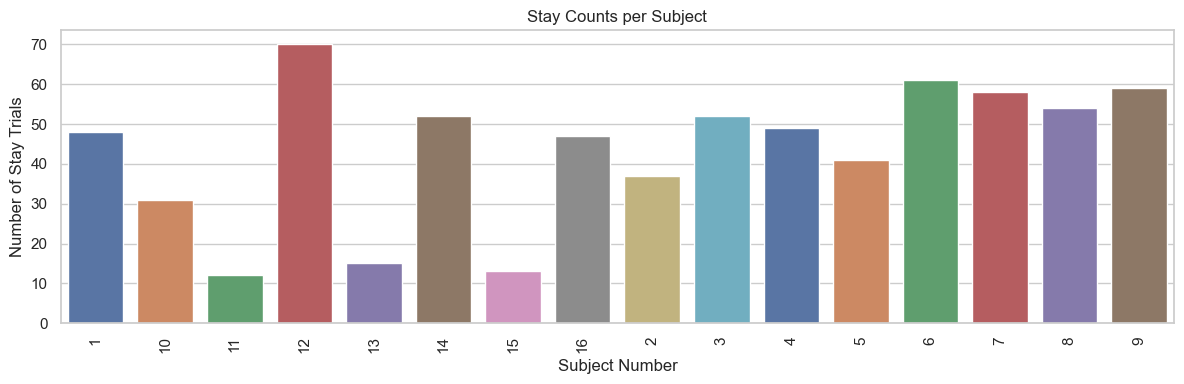

In [157]:

# 1) compute “stay” by comparing each trial’s choice to the *previous* trial for the same subject
data['stay'] = (
    data['chosen_prob']
      .eq(data.groupby('sub_num')['chosen_prob'].shift(1))
      .fillna(False)
      .astype(int)
)

# 2) count stays per subject
stay_counts = (
    data
    .groupby('sub_num')['stay']
    .sum()
    .reset_index(name='stay_count')
)

# 3) print the table
print(stay_counts)

# 4) plot
plt.figure(figsize=(12, 4))
sns.barplot(
    x='sub_num',
    y='stay_count',
    data=stay_counts,
    palette='deep'
)
plt.xlabel('Subject Number')
plt.ylabel('Number of Stay Trials')
plt.title('Stay Counts per Subject')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Exploratory analysis

In [136]:
import pandas as pd
import statsmodels.formula.api as smf

# 1. Build lags within each sub×block
df = data.copy().sort_values(['sub','block','trial_in_round'])
df['prev_choice'] = df.groupby(['sub','block'])['choice'].shift(1)
df['prev_reward'] = df.groupby(['sub','block'])['outcome'].shift(1)
df=df[df['round']==0]
# 2. Define stay = 1 if current choice == prev_choice, else 0
df['stay'] = (df['choice'] == df['prev_choice']).astype(int)

# 4a. If you just want an OLS “probability” model:
logit_mod = smf.logit(
    formula='stay ~ prev_reward*RTz',
    data=df
).fit()
print(logit_mod.summary())

df = data.copy().sort_values(['sub','block','trial_in_round'])
df['prev_choice'] = df.groupby(['sub','block'])['choice'].shift(1)
df['prev_reward'] = df.groupby(['sub','block'])['outcome'].shift(1)
df=df[df['round']==1]
# 2. Define stay = 1 if current choice == prev_choice, else 0
df['stay'] = (df['choice'] == df['prev_choice']).astype(int)

# 4a. If you just want an OLS “probability” model:
logit_mod = smf.logit(
    formula='stay ~ prev_reward*RTz',
    data=df
).fit()
print(logit_mod.summary())

Optimization terminated successfully.
         Current function value: 0.609023
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   stay   No. Observations:                  625
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                  0.1171
Time:                        13:10:25   Log-Likelihood:                -380.64
converged:                       True   LL-Null:                       -431.13
Covariance Type:            nonrobust   LLR p-value:                 9.525e-22
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0181      0.091      0.199      0.842      -0.160       0.196
prev_reward   

Skipping subject prolific_59e4b3a1896cfc0001921095 due to error: Singular matrix


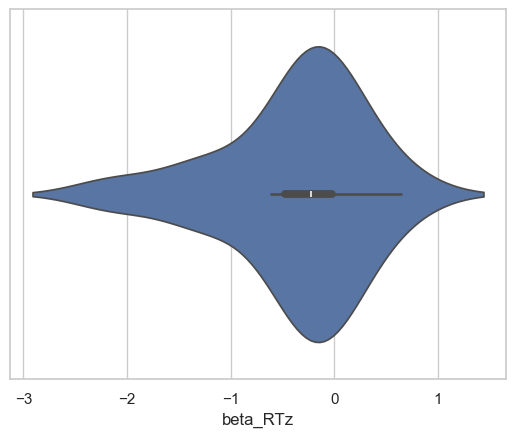

In [148]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import spearmanr

# Step 1: Prepare the data
df = data.copy().sort_values(['sub', 'block', 'trial_in_round'])
df['prev_choice'] = df.groupby(['sub', 'block'])['choice'].shift(1)
df['prev_reward'] = df.groupby(['sub', 'block'])['outcome'].shift(1)
df['stay'] = (df['choice'] == df['prev_choice']).astype(int)

df=df[df['round']>-1]

# Step 2: Run logistic regression per subject and collect parameters
results = []

for sub_id, sub_df in df.dropna(subset=['prev_choice', 'prev_reward']).groupby('sub'):
    try:
        model = smf.logit('stay ~ prev_reward*RTz', data=sub_df).fit(disp=False)
        beta_prev_reward = model.params['RTz']
        mean_choose_best = sub_df['choose_actual_best'].mean()
        results.append({'sub': sub_id,
                        'beta_RTz': beta_prev_reward,
                        'mean_choose_best': mean_choose_best})
    except Exception as e:
        print(f"Skipping subject {sub_id} due to error: {e}")

results_df = pd.DataFrame(results)

sns.violinplot(data=results_df,x='beta_RTz')
plt.show()

